In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy
from pathlib import Path
import pickle
import os
from scipy.stats import linregress
import sys

repo_path = str(Path().resolve().parent.parent)
os.chdir(repo_path)
sys.path.append(repo_path)

from src.turbidity_time_series.load_clean_data import load_and_clean_data

In [2]:
bouctouche_turbidity_probe_geo_coordinate =  {"lat": 46.417321, "lon": -64.812698}
cocagne_turbidity_probe_geo_coordinate =  {"lat": 46.324828, "lon": -64.669282}

In [119]:
def get_image_list_from_estuary_name_year(estuary_name, year, max_cloud_coverage, turbidity_probe_geo_coordinate):
    image_class_path_list = list(filter(lambda path: year in str(path), list(Path(f"data/{estuary_name}_class").iterdir())))
    image_list = []
    for image_class_path in image_class_path_list:
        with open(image_class_path, "rb") as f:
            image_class = pickle.load(f)
        # row, col = image_class.get_row_col_index_from_longitide_latitude(
        #     turbidity_probe_geo_coordinate["lon"],
        #     turbidity_probe_geo_coordinate["lat"]
        # )
        # row = int(row)
        # col = int(col)
        # cloud_around_geo_coordinates = image_class.cloud_prob[row-50:row+50, col-50:col+50]

        # if cloud_around_geo_coordinates.max() < 5:
        if image_class.calculated_cloud_coverage < max_cloud_coverage:
            image_list.append(image_class)
    return image_list

In [120]:
bouctouche_image_list = get_image_list_from_estuary_name_year("bouctouche", "2022", 0.01, bouctouche_turbidity_probe_geo_coordinate)

In [121]:
cocagne_image_list = get_image_list_from_estuary_name_year("cocagne", "2022", 0.01, cocagne_turbidity_probe_geo_coordinate)

In [110]:
bouctouche_turbidity = load_and_clean_data("data/2022_data/Bouctouche.csv")

In [111]:
cocagne_turbidity = load_and_clean_data("data/2022_data/Cocagne.csv")

In [112]:
def get_turbidity_from_image_handle_class_and_turbidity_df(image_handle_class, turbidity_df):
    image_date = datetime.strptime(image_handle_class.date[:-5], "%Y-%m-%dT%H:%M:%S")
    idx_location = (turbidity_df["date"] - image_date).abs().argmin()
    turbidity = turbidity_df.loc[idx_location]["turbidity"]
    time_diff = (turbidity_df.loc[idx_location]["date"] - image_date)
    return turbidity, time_diff

In [125]:
bouctouche_img_list_turbidty_value = []
for image in bouctouche_image_list:
    turbidity, time_diff = get_turbidity_from_image_handle_class_and_turbidity_df(image, bouctouche_turbidity)
    image_date = datetime.strptime(image.date[:-5], "%Y-%m-%dT%H:%M:%S")
    if numpy.abs(time_diff).days == 0 and image_date < datetime(2022,9,21):
        bouctouche_img_list_turbidty_value.append((image, turbidity))

In [137]:
cocagne_img_list_turbidty_value = []
for image in cocagne_image_list:
    turbidity, time_diff = get_turbidity_from_image_handle_class_and_turbidity_df(image, cocagne_turbidity)
    image_date = datetime.strptime(image.date[:-5], "%Y-%m-%dT%H:%M:%S")
    if numpy.abs(time_diff).days == 0 and image_date < datetime(2022,9,21):
        cocagne_img_list_turbidty_value.append((image, turbidity))

In [139]:
row, col = cocagne_img_list_turbidty_value[1][0].get_row_col_index_from_longitide_latitude(
    cocagne_turbidity_probe_geo_coordinate["lon"],
    cocagne_turbidity_probe_geo_coordinate["lat"]
)
row = int(row)
col = int(col)

In [140]:
len(bouctouche_img_list_turbidty_value)

4

In [141]:
# fig = plt.figure(figsize=(10,10))
# plt.imshow(cocagne_img_list_turbidty_value[0][0].true_color_image[600:, :800, :])
# plt.scatter(col_cocagne, row_cocagne-600, s=10)

In [142]:
bouctouche_red_green_blue_nir_ndti_turbidity = []
for img, turbidity_value in bouctouche_img_list_turbidty_value:
    row, col = img.get_row_col_index_from_longitide_latitude(
        bouctouche_turbidity_probe_geo_coordinate["lon"],
        bouctouche_turbidity_probe_geo_coordinate["lat"]
    )
    row, col = int(row), int(col)
    mean_red = img.red_band.astype(float).mean()
    std_red = img.red_band.astype(float).std()
    blue_value = img.blue_band[row, col].astype(float)
    red_value = img.red_band[row, col].astype(float)
    green_value = img.green_band[row, col].astype(float)
    nir_value = img.nir_band[row, col].astype(float)
    ndti_value = (red_value - green_value)/(red_value + green_value)
    bouctouche_red_green_blue_nir_ndti_turbidity.append(
        [(img.red_band[row, col].astype(float) - mean_red)/std_red, green_value, blue_value, nir_value, ndti_value, turbidity_value]
    )
bouctouche_red_green_blue_nir_ndti_turbidity = numpy.array(bouctouche_red_green_blue_nir_ndti_turbidity)    

In [143]:
cocagne_red_green_blue_nir_ndti_turbidity = []
for img, turbidity_value in cocagne_img_list_turbidty_value:
    row, col = img.get_row_col_index_from_longitide_latitude(
        cocagne_turbidity_probe_geo_coordinate["lon"],
        cocagne_turbidity_probe_geo_coordinate["lat"]
    )
    row, col = int(row), int(col)
    mean_red = img.red_band.astype(float).mean()
    std_red = img.red_band.astype(float).std()
    blue_value = img.blue_band[row, col].astype(float)
    red_value = img.red_band[row, col].astype(float)
    green_value = img.green_band[row, col].astype(float)
    nir_value = img.nir_band[row, col].astype(float)
    ndti_value = (red_value - green_value)/(red_value + green_value)
    cocagne_red_green_blue_nir_ndti_turbidity.append(
        [img.red_band[row, col].astype(float), green_value, blue_value, nir_value, ndti_value, turbidity_value]
    )
cocagne_red_green_blue_nir_ndti_turbidity = numpy.array(cocagne_red_green_blue_nir_ndti_turbidity)    

In [144]:
bouctouche_lr = linregress(bouctouche_red_green_blue_nir_ndti_turbidity[:, 4], bouctouche_red_green_blue_nir_ndti_turbidity[:, 5])
cocagne_lr = linregress(cocagne_red_green_blue_nir_ndti_turbidity[:, 4], cocagne_red_green_blue_nir_ndti_turbidity[:, 5])

In [145]:
cocagne_lr.rvalue

0.16802299225055484

In [146]:
x = numpy.arange(-0.05, 0.05, 0.01)

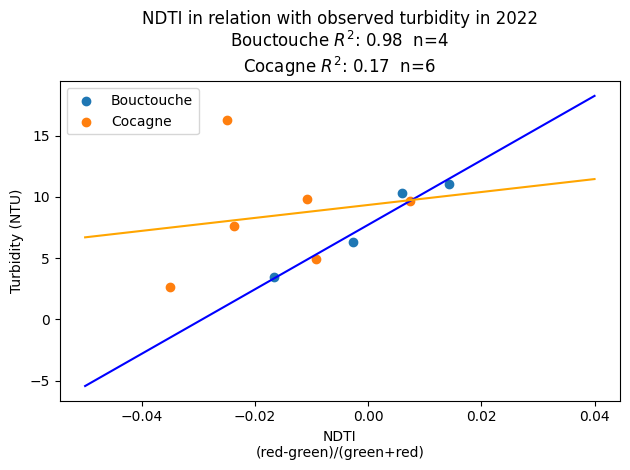

In [155]:
plt.scatter(bouctouche_red_green_blue_nir_ndti_turbidity[:, 4], bouctouche_red_green_blue_nir_ndti_turbidity[:, 5], label="Bouctouche")
plt.scatter(cocagne_red_green_blue_nir_ndti_turbidity[:, 4], cocagne_red_green_blue_nir_ndti_turbidity[:, 5], label="Cocagne")
plt.plot(x, bouctouche_lr.intercept + bouctouche_lr.slope*x, c="blue")
plt.plot(x, cocagne_lr.intercept + cocagne_lr.slope*x, c="orange")
plt.title(
    f"NDTI in relation with observed turbidity in 2022"
    f"\nBouctouche $R^2$: {round(bouctouche_lr.rvalue, 2)}  n={len(bouctouche_red_green_blue_nir_ndti_turbidity)}"
    f"\nCocagne $R^2$: {round(cocagne_lr.rvalue, 2)}  n={len(cocagne_red_green_blue_nir_ndti_turbidity)}"
)
plt.xlabel("NDTI\n(red-green)/(green+red)")
plt.ylabel("Turbidity (NTU)")
plt.legend()
plt.tight_layout()
plt.savefig("Measured turbidity")
plt.show()

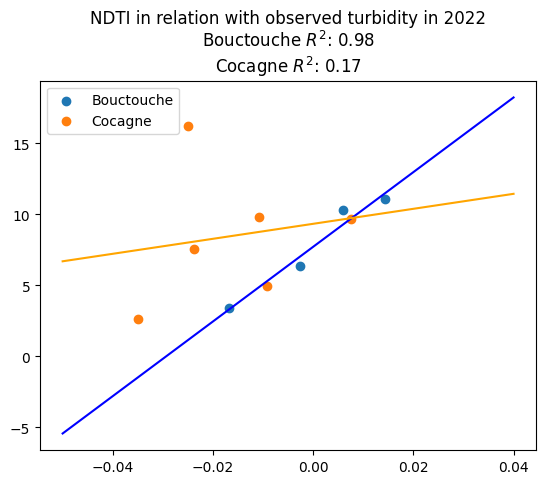

In [140]:
plt.scatter(bouctouche_red_green_blue_nir_ndti_turbidity[:, 4], bouctouche_red_green_blue_nir_ndti_turbidity[:, 5], label="Bouctouche")
plt.scatter(cocagne_red_green_blue_nir_ndti_turbidity[:, 4], cocagne_red_green_blue_nir_ndti_turbidity[:, 5], label="Cocagne")
plt.plot(x, bouctouche_lr.intercept + bouctouche_lr.slope*x, c="blue")
plt.plot(x, cocagne_lr.intercept + cocagne_lr.slope*x, c="orange")
plt.title(
    f"NDTI in relation with observed turbidity in 2022"
    f"\nBouctouche $R^2$: {round(bouctouche_lr.rvalue, 2)}"
    f"\nCocagne $R^2$: {round(cocagne_lr.rvalue, 2)}"
)
plt.legend()
plt.show()